- [How to select a clustering method?](https://stats.stackexchange.com/questions/195456/how-to-select-a-clustering-method-how-to-validate-a-cluster-solution-to-warran)
- [What is a good way to choose initial points of k clusters in k-means clustering?](https://www.quora.com/What-is-a-good-way-to-choose-initial-points-of-k-clusters-in-k-means-clustering)
- [Robust seed selection algorithm for k-means type algorithms (2012)](https://arxiv.org/abs/1202.1585)

In [1]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import KFold
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
# set defualt  size for plotting



import dataset
dataset.prepare_dataset('data')

File exist! skip download
Files already extracted


                 a1            a2            a3            a4            a5  \
count  17898.000000  17898.000000  17898.000000  17898.000000  17898.000000   
mean     111.079968     46.549532      0.477857      1.770279     12.614400   
std       25.652935      6.843189      1.064040      6.167913     29.472897   
min        5.812500     24.772042     -1.876011     -1.791886      0.213211   
25%      100.929688     42.376018      0.027098     -0.188572      1.923077   
50%      115.078125     46.947479      0.223240      0.198710      2.801839   
75%      127.085938     51.023202      0.473325      0.927783      5.464256   
max      192.617188     98.778911      8.069522     68.101622    223.392140   

                 a6            a7            a8         label  
count  17898.000000  17898.000000  17898.000000  17898.000000  
mean      26.326515      8.303556    104.857709      0.091574  
std       19.470572      4.506092    106.514540      0.288432  
min        7.370432     -3.13927

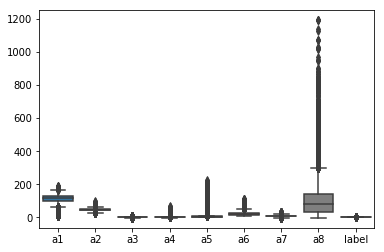

In [2]:
df = pd.read_csv('data/HTRU_2.csv', header=None, names=['a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'label'])
df_wo_class = df.drop(columns=['label'])

print(df.describe())
sns.boxplot(data=df)

In [3]:
class StandardScaler(object):
    def fit(self, X):
        self.mean = X.mean()
        size = X.shape[0]
        self.mean_absolute_deviation = np.abs(X - self.mean).sum() / size
        return self
    
    def transform(self, X):
        return (X - self.mean) / self.mean_absolute_deviation

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

class AbsoluteLogScaler(object):
    def fit(self, X):
        return self
        
    def transform(self, X):
        def abs_log(value):
            return np.log2(value) if value >= 0 else -np.log2(-value)
        
        return X * 3

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

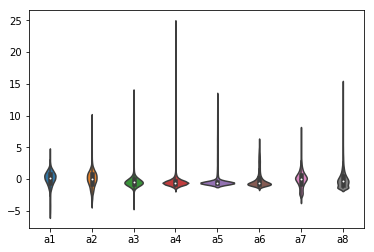

In [4]:
class DataProcessor(object):
    def fit(self, dataframe):
        self.a1 = StandardScaler().fit(dataframe.a1)
        self.a2 = StandardScaler().fit(dataframe.a2)
        self.a3 = StandardScaler().fit(dataframe.a3)
        self.a4 = StandardScaler().fit(dataframe.a4)
        self.a5 = StandardScaler().fit(dataframe.a5)
        self.a6 = StandardScaler().fit(dataframe.a6)
        self.a7 = StandardScaler().fit(dataframe.a7)
        self.a8_1 = AbsoluteLogScaler().fit(dataframe.a8)
        self.a8_2 = StandardScaler().fit(self.a8_1.transform(dataframe.a8))
        
    def transform(self, dataframe):
        dataframe = dataframe.copy()
        
        dataframe.a1 = self.a1.transform(dataframe.a1)
        dataframe.a2 = self.a2.transform(dataframe.a2)
        dataframe.a3 = self.a3.transform(dataframe.a3)
        dataframe.a4 = self.a4.transform(dataframe.a4)
        dataframe.a5 = self.a5.transform(dataframe.a5)
        dataframe.a6 = self.a6.transform(dataframe.a6)
        dataframe.a7 = self.a7.transform(dataframe.a7)
        dataframe.a8 = self.a8_2.transform(self.a8_1.transform(dataframe.a8))
        
        return dataframe
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)
        
p = DataProcessor()
df_clean = p.fit_transform(df)
df_clean = df_clean.drop(columns=['label'])
sns.violinplot(data=df_clean)

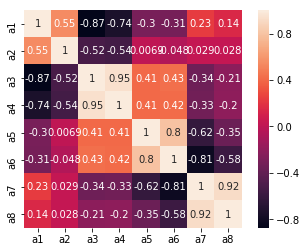

In [5]:
corelation = df_clean.corr()
sns.heatmap(corelation, square=True, annot=True)

In [14]:
from sklearn.metrics.pairwise import pairwise_distances
from copy import deepcopy

def distance(n_root):
    def d(i, j):
        return  np.sum(np.abs(i - j) ** n_root) ** (1/n_root)
    
    return d


def euclidean():
    return distance(2)


class KMeanSPSS(object):
    def __init__(self
                 , n_cluster
                 , metric='euclidean'
                 , verbose=False
                 , max_iteration=300
                 , tolerance=1e-4
                 , n_jobs=1
                 , ):
        self.__dict__.update(locals())
        del self.self # We don't need this either
        
        self.labels = []
        self.cluster_centers = []
        self.sse = np.inf
        
        
    def _log(self, message):
        if self.verbose: print(message)
    
    
    def _distance(self, X, Y):
        return pairwise_distances(
            X=X
            , Y=Y
            , metric=self.metric
            , n_jobs=self.n_jobs)
    
    
    def _distance_to_nearest_centoid(self, data):
        distances = self._distance(data, self.cluster_centers)
        
        return distances.min(axis=1)
    
    
    def _nearest_centoid(self, data):
        distances = self._distance(data, self.cluster_centers)

        return distances.argmin(axis=1)
    
    def _sum_square_error(self, data):
        return np.sum(self._distance_to_nearest_centoid(data) ** 2)
            
    
    def _init_clusters(self, data):
        self._log("init clusters")
        m = data.shape[0]
        average_cluster_size = int(m / self.n_cluster)
        
        # step 1 calculate distance matrix
        dissimilarity = pairwise_distances(
            data
            , n_jobs=self.n_jobs
            , metric=self.metric)
        
        # step 2 find sumv which sumv(i) in the sum of the distances 
        # from Xi point to all other points
        sumv = dissimilarity.sum(axis=0)
        
        # step 3 find index h of minimim value of sumv
        h_index = np.unravel_index(sumv.argmin(), sumv.shape)[0]
        x_h = data[h_index]
        
        # step 4 Add Xh as the first centroid
        self._log(f" - First cluster center:{x_h}")
        self.cluster_centers = [x_h]
        
        selected_index = set([h_index])
        
        while len(self.cluster_centers) < self.n_cluster:
            # step 5 calculate d(Xi) which is distance 
            # between Xi and nearest centroid
            d = self._distance_to_nearest_centoid(data)
            d2 = d ** 2
            self._log(f" - distance to nearest controid: {d}")

            # step 6 find y as th e sum of distances of 
            # first m/k nearest points from Xh
            distance_from_xh = dissimilarity[h_index]
            sorted_distance = np.sort(distance_from_xh)
            y = np.sum(sorted_distance[:average_cluster_size])
            self._log(f" - y = {y}")

            # step 7-8 find i that satisfy 
            # d(X1)2+d(X2)2+...+d(Xi)2> = y>d(X1)2+d(X2)2+...+d(X(i-1))2
            select_i = -1
            self._log(f" - Sum d = {np.sum(d ** 2)}")
            for i in range(m):
                if np.sum(d2[:i]) >= y and y > np.sum(d2[:i-1]) and i not in selected_index:
                    select_i = i
                    selected_index.add(i)
                    break
                    
            if select_i == -1:
                raise Exception("Can't init cluster")
                
            self._log(f" - Next cluster index: {select_i}")

            # step 9 add Xi as new centroid
            self.cluster_centers += [data[select_i]]
        
        self.cluster_centers = np.array(self.cluster_centers)
        self._log(f"end init clusters: {self.cluster_centers}")
    
    
    def _update_cost(self, old_cluster_centers, new_cluster_centers):
        costs = self._distance(old_cluster_centers, new_cluster_centers)
        costs = np.array([costs[i, i] for i in range(self.n_cluster)])
        
        return costs

    
    def _update_cluster_centers(self, data, new_labels):
        old_cluster_centers = deepcopy(self.cluster_centers)
        
        new_cluster_centers = []
        for label in range(self.n_cluster):
            members = data[new_labels == label]
            new_cluster_centers += [members.mean(axis=0)]
        
        self.cluster_centers = np.array(new_cluster_centers)
        self.labels = self._nearest_centoid(data)
        
        costs = self._update_cost(old_cluster_centers, new_cluster_centers)
        self._log(f" - update costs: {costs}")
        
        is_optimal = not np.any(costs > self.tolerance)
        self._log(f" - optimal: {is_optimal}")
        
        return is_optimal
    
        
    def fit(self, data):
        self.labels = []
        self.cluster_centers = []
        
        # convert pandas DataFrame to numpy ndarray
        # for better performance
        if type(data) is pd.DataFrame:
            data = data.as_matrix()
            
        self._init_clusters(data)
        
        # start clustering
        for it in range(self.max_iteration):
            self._log(f"iteration {it:4}")
            local_labels = self._nearest_centoid(data)
            is_optimal = self._update_cluster_centers(data, local_labels)
            
            if is_optimal:
                break
                
        self.sse = self._sum_square_error(data)
                
        return self
    
    
    def predict(self, data):
        return self._nearest_centoid(data)
    
    
cluster = KMeanSPSS(n_cluster=2, metric='cosine', verbose=True).fit(df_clean)

init clusters
 - First cluster center:[ 0.16954884  0.06491949 -0.47717165 -0.65346259 -0.63931725 -0.55713695
  0.28386431 -0.14565274]
 - distance to nearest controid: [0.37450423 0.52135904 0.65467247 ... 1.1540801  0.29381317 1.54311412]
 - y = 2741.6835900117703
 - Sum d = 12102.773913390873
 - Next cluster index: 3887
end init clusters: [[ 0.16954884  0.06491949 -0.47717165 -0.65346259 -0.63931725 -0.55713695
   0.28386431 -0.14565274]
 [ 1.50760879  1.1450391  -1.20256455 -0.73772123 -0.47206094  0.08664838
  -0.60050287 -0.87253438]]
iteration    0
 - update costs: [0.30345047 0.86258315]
 - optimal: False
iteration    1
 - update costs: [0.04026797 0.04026797]
 - optimal: False
iteration    2
 - update costs: [0.00852623 0.00852623]
 - optimal: False
iteration    3
 - update costs: [0.00183995 0.00183995]
 - optimal: False
iteration    4
 - update costs: [0.00041186 0.00041186]
 - optimal: False
iteration    5
 - update costs: [7.88226269e-05 7.88226269e-05]
 - optimal: True


In [7]:
from sklearn.decomposition import PCA

def plot3d(dataframe, labels):
    unique_labels = np.unique(labels)
    
    pca = PCA(n_components=3)
    df_reduced = pca.fit_transform(df_clean)
    
    plot_datas = []
    for label in unique_labels:
        local_data = df_reduced[labels==label]

        plot_datas += [go.Scatter3d(
            x=local_data[:,0],
            y=local_data[:,1],
            z=local_data[:,2],
            mode='markers',
            marker=dict(
                size=6,
                line=dict(
                    color='rgba(217, 217, 217, 0.14)',
                    width=0.05
                ),
                opacity=0.5
            )
        )]

    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    
    fig = go.Figure(data=plot_datas, layout=layout)
    return py.iplot(fig, filename='simple-3d-scatter')

In [24]:
cluster = KMeanSPSS(n_cluster=2, metric='l1').fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels)

[[ 0.2569698   0.13692394 -0.43054671 -0.48780731 -0.21463    -0.17772481
   0.13502955  0.09339413]
 [-3.84949937 -2.05116959  6.44974351  7.30752772  3.21523411  2.66238107
  -2.02279082 -1.39907748]] 1003412.8312470393


In [22]:
# cluster = KMeanSPSS(n_cluster=2, metric='cosine').fit(df_clean)
# print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, df['label'])

In [9]:
cluster = KMeanSPSS(n_cluster=3).fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels)

[[ 0.22283578  0.0599448  -0.40411507 -0.46547266 -0.55823084 -0.44192515
   0.30837389  0.19962984]
 [-4.19910778 -2.4015702   7.37443427  8.81864408  3.32129474  2.63844385
  -2.03706459 -1.40190052]
 [ 0.12247184  0.87385615 -0.06298056 -0.28709521  4.45182924  3.5182678
  -2.32548016 -1.4504387 ]] 159566.9689922513


In [10]:
cluster = KMeanSPSS(n_cluster=4).fit(df_clean)
print(cluster.cluster_centers, cluster.sse)
plot3d(df_clean, cluster.labels)

[[ 0.17876449  0.97060916 -0.11017991 -0.30799029  5.09865455  3.69179865
  -2.41267117 -1.45782599]
 [ 0.15569894 -0.02767349 -0.40717838 -0.46918933 -0.70473631 -1.0134915
   1.92002164  2.31218255]
 [ 0.23226182  0.08628805 -0.3914853  -0.45779903 -0.49619366 -0.24366089
  -0.1514154  -0.38376365]
 [-4.20504722 -2.40462098  7.39557354  8.85350582  3.31654067  2.65099245
  -2.04103815 -1.40374925]] 127835.46087666905


In [11]:
for k in range(2, 11):
    try:
        cluster = KMeanSPSS(n_cluster=k, verbose=False).fit(df_clean)
        print(k, cluster.sse)
    except:
        print(k, "cant init cluster")

2 220087.61926540302
3 159566.9689922513
4 127835.46087666905
5 cant init cluster
6 cant init cluster
7 cant init cluster
8 cant init cluster
9 cant init cluster
10 cant init cluster


In [12]:
print(1)

1
